>>  Import package => OKAY

petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc
petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2

/home/mul450/miniconda3/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ocn_sur_temp
  _locR 0 proxy_frac 0.7 scaled r 1.0
    30.035 ± 1.041: pre-PETM
    35.273 ± 1.279: peak-PETM
    32.276 ± 1.016: post-PETM
    33.775 ± 1.095: PETM body
    5.237907 ± 0.925218: peak warming
    -2.996340 ± 0.821420: peak cooling
atm_temp
  _locR 0 proxy_frac 0.7 scaled r 1.0
    26.589 ± 1.219: pre-PETM
    32.725 ± 1.497: peak-PETM
    29.214 ± 1.188: post-PETM
    30.975 ± 1.282: PETM body
    6.135614 ± 1.082246: peak warming
    -3.510977 ± 0.966959: peak cooling
atm_pCO2
  _locR 0 proxy_frac 0.7 scaled r 1.0
    1268.065 ± 233.063: pre-PETM
    2084.252 ± 276.918: peak-PETM
    1609.079 ± 241.778: post-PETM
    1872.676 ± 250.421: PETM body
    816.186660 ± 198.055212: peak warming
    -475.172851 ± 195.096287: peak cooling
ocn_sur_sal
  _locR 0 proxy_frac 0.7 scaled r 1.0
    33.670 ± 0.019: pre-PETM
    33.610 ± 0.022: peak-PETM
    33.644 ± 0.020: post-PETM
    33.629 ± 0.020: PETM body
    -0.060284 ± 0.013419: peak warming
    0.034335 ± 0.010702: peak cooli

/home/mul450/miniconda3/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:336: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


atm_pCO2
  _locR 0 proxy_frac 0.7 scaled r 1.0
    2176.259 ± 655.273: peak-PETM
ocn_sur_sal
  _locR 0 proxy_frac 0.7 scaled r 1.0
    33.597 ± 0.067: peak-PETM
misc_pH
  _locR 0 proxy_frac 0.7 scaled r 1.0
    7.355 ± 0.168: peak-PETM
carb_sur_ohm_cal
  _locR 0 proxy_frac 0.7 scaled r 1.0
    3.229 ± 1.402: peak-PETM
sed_CaCO3
  _locR 0 proxy_frac 0.7 scaled r 1.0
    28.766 ± 6.905: peak-PETM
saved @
/mnt/c/Users/mul450/Dropbox/git/deepDA/mlwrk/wrk/petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2021011_ca_e2500_100mc.summary.xlsx
petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2021011_ca_e2500_100mc
>>  Loading configuration file => OKAY

['sed_CaCO3', 'atm_pCO2']
>>  nc_keyvalue {'biogem': 'fields_biogem_2d', 'sedgem': 'fields_sedgem_2d'}...
>>  biogem: fields_biogem_2d
>>  sedgem: fields_sedgem_2d
>>  nc_keyvalue {'biogem': 'fields_biogem_3d'}...
>>  biogem: fields_biogem_3d
>>  Number of 2d prior variables is: 7. List:
      ['ocn_sur_temp', 'atm_temp', 'atm_pCO2', 'ocn_sur_sal

/home/mul450/miniconda3/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:336: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


atm_pCO2
  _locR 0 proxy_frac 0.7 scaled r 1.0
    2478.148 ± 619.179: peak-PETM
ocn_sur_sal
  _locR 0 proxy_frac 0.7 scaled r 1.0
    33.581 ± 0.065: peak-PETM
misc_pH
  _locR 0 proxy_frac 0.7 scaled r 1.0
    7.279 ± 0.151: peak-PETM
carb_sur_ohm_cal
  _locR 0 proxy_frac 0.7 scaled r 1.0
    2.691 ± 1.215: peak-PETM
sed_CaCO3
  _locR 0 proxy_frac 0.7 scaled r 1.0
    24.448 ± 3.558: peak-PETM
saved @
/mnt/c/Users/mul450/Dropbox/git/deepDA/mlwrk/wrk/petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2021011_ca_e400_100mc.summary.xlsx
petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2021011_ca_e400_100mc
>>  Loading configuration file => OKAY

['sed_CaCO3', 'atm_pCO2']
>>  nc_keyvalue {'biogem': 'fields_biogem_2d', 'sedgem': 'fields_sedgem_2d'}...
>>  biogem: fields_biogem_2d
>>  sedgem: fields_sedgem_2d
>>  nc_keyvalue {'biogem': 'fields_biogem_3d'}...
>>  biogem: fields_biogem_3d
>>  Number of 2d prior variables is: 7. List:
      ['ocn_sur_temp', 'atm_temp', 'atm_pCO2', 'ocn_sur_sal',

/home/mul450/miniconda3/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:336: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


atm_pCO2
  _locR 0 proxy_frac 0.7 scaled r 1.0
    2329.239 ± 626.400: peak-PETM
ocn_sur_sal
  _locR 0 proxy_frac 0.7 scaled r 1.0
    33.591 ± 0.065: peak-PETM
misc_pH
  _locR 0 proxy_frac 0.7 scaled r 1.0
    7.312 ± 0.154: peak-PETM
carb_sur_ohm_cal
  _locR 0 proxy_frac 0.7 scaled r 1.0
    2.898 ± 1.246: peak-PETM
sed_CaCO3
  _locR 0 proxy_frac 0.7 scaled r 1.0
    25.821 ± 4.639: peak-PETM
saved @
/mnt/c/Users/mul450/Dropbox/git/deepDA/mlwrk/wrk/petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2021011_ca_e900_100mc.summary.xlsx


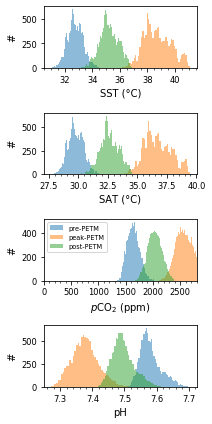

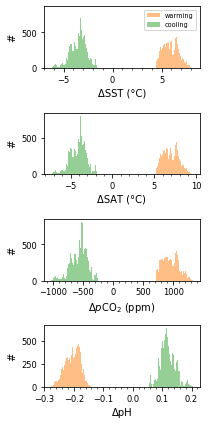

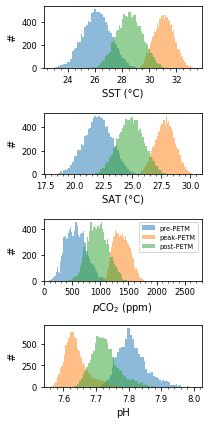

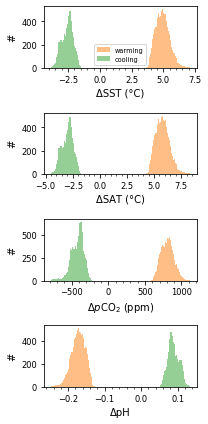

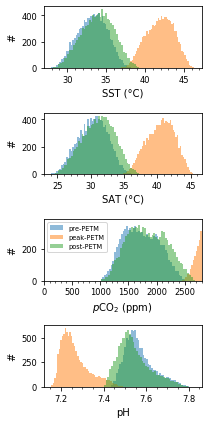

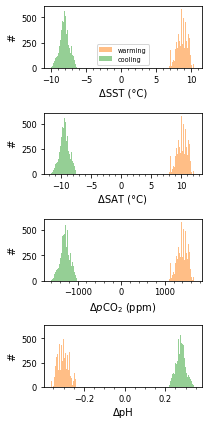

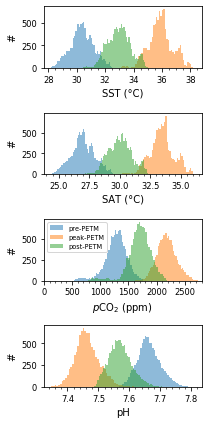

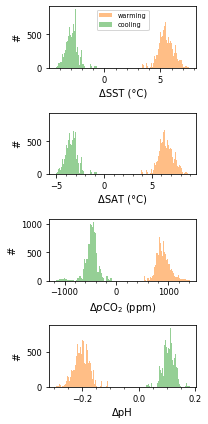

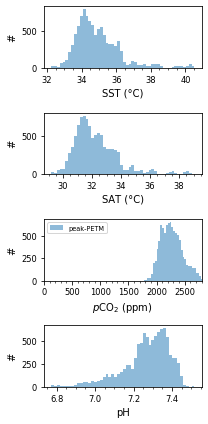

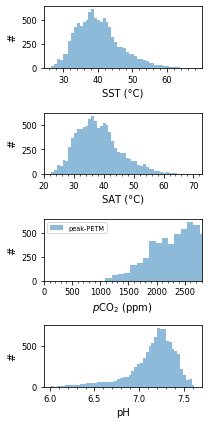

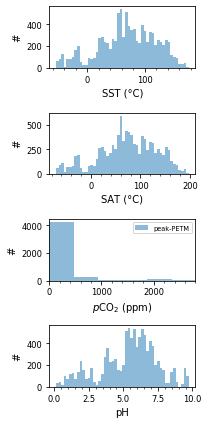

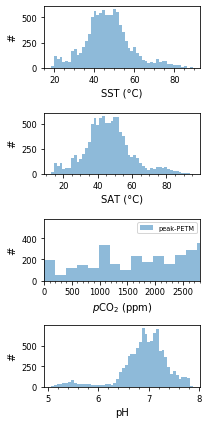

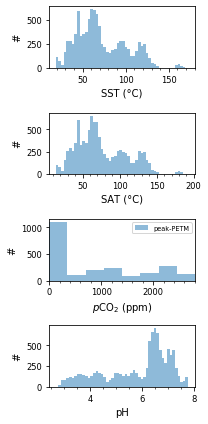

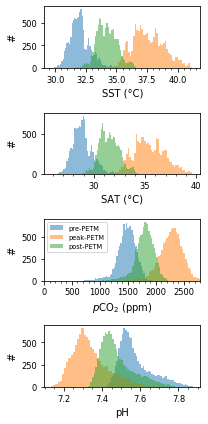

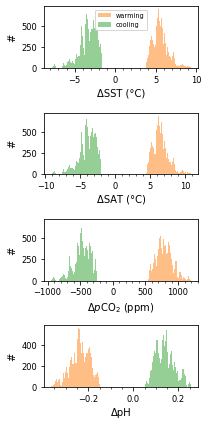

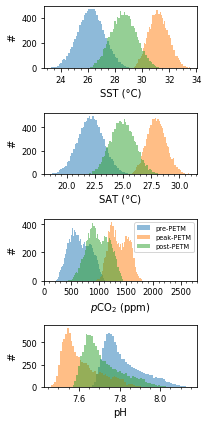

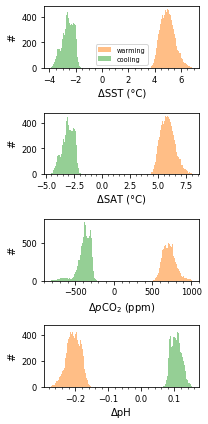

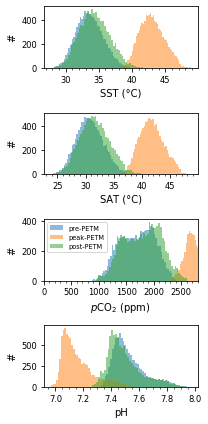

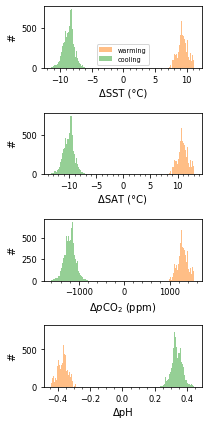

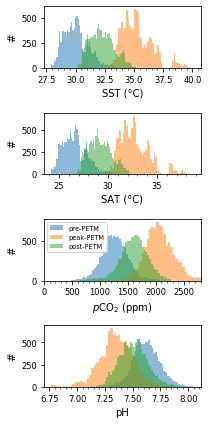

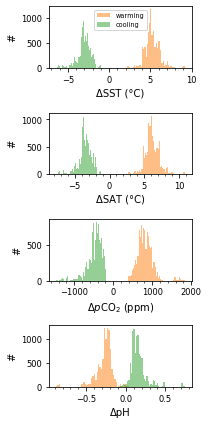

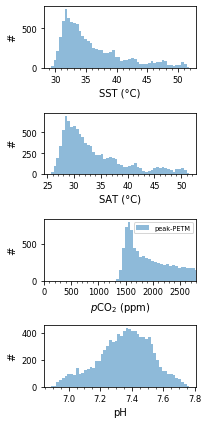

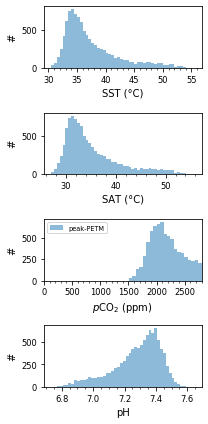

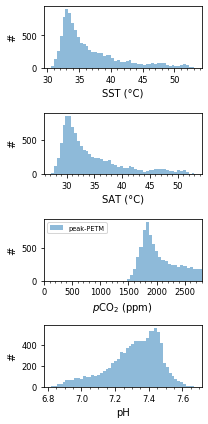

In [6]:
'''
DeepDA_verify is to verify DA output. 
It read proxy, prior, and posterior from DA outputs files and config file.
It calculates the statistics of the DA results and save the outputs.
By Mingsong Li
Penn State
2/17/2020
Updated Mar. 03, 2020
Updated Oct. 11, 2020  # plot enhanced
Updated Oct. 12, 2020  # multi jobs

    for Monte Carlo simulations:
'''
import sys
sys.path.append('../')
from DeepDA_lib import modules_nc
from DeepDA_lib import DeepDA_psm
from scipy import stats
import shutil

import h5py
#import time
import yaml
import numpy as np
import pandas
import os
from netCDF4 import Dataset
from sys import platform as sys_pf
import matplotlib.pyplot as plt
if sys_pf == 'darwin':
    import matplotlib
    matplotlib.use("TkAgg")
    import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
try:
    import bayspline
except ImportError as e1:
    print('Warning:', e1)
try:
    import bayspar
except ImportError as e2:
    print('Warning:', e2)
try:
    import bayfox
except ImportError as e3:
    print('Warning:', e3)
try:
    import baymag
except ImportError as e4:
    print('Warning:', e4)

print('>>  Import package => OKAY')
print('')
#####################    User defined start   #####################

xlsxdir = '/mnt/d/DeepDA/wrk/'

import os

d = xlsxdir
dir1 = [o for o in os.listdir(d) if os.path.isdir(os.path.join(d,o))]
#print(dir1[0])
for diri in range(len(dir1)):
    print(en)
    if diri < 16:
        continue
    en = dir1[diri]   

#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_all_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_ca_e1_100mc'  # bad
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_ca_e4_100mc'  # too cold?
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_ca_e25_100mc' # better?
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_ca_e100_100mc' # reasonable
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2021011_ca_e400_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2021011_ca_e900_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2021011_ca_e2500_100mc'#

#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_mg_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_o_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_tex_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_TOM_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2020918_all_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2020918_ca_e1_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2020918_ca_e4_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2020918_ca_e25_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2020918_ca_e100_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2020918_mg_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2020918_o_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2020918_tex_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2020918_TOM_100mc'


#en = 'petmproxy3slices_v0.0.18.csv_petm17_v18_2021011_ca_e100_100mc'
#en = 'petmproxy3slices_v0.0.18.csv_petm18_v18_2021011_ca_e100_100mc'
#en = 'petmproxy3slices_v0.0.18.csv_petm18_v18_2021011_ca_e400_100mc'
#en = 'petmproxy3slices_v0.0.18.csv_petm18_v18_2021011_ca_e900_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus.csv_petm17_v18h_2021011_ca_e100_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus.csv_petm18_v18h_2021011_ca_e100_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus.csv_petm18_v18h_2021011_ca_e400_100mc'
#en = 'petmproxy3slices_v0.0.18hiatus.csv_petm18_v18h_2021011_ca_e900_100mc'

    dum_jmax = 36
    dum_imax = 36
    dum_ijmax = dum_imax * dum_jmax

    AnalysisStd = True   # True: standardize; False: use raw analysis data

    #####################    User defined end     #####################

    config_name_f = "../DeepDA_config.yml"
    f = open(config_name_f, 'r')
    yml_dict_f = yaml.load(f, Loader=yaml.FullLoader)
    f.close()

    dir_data_save = yml_dict_f['core']['wrkdir']

    config_name = dir_data_save + '/' + en + '.yml'
    f = open(config_name, 'r')
    yml_dict = yaml.load(f, Loader=yaml.FullLoader)
    f.close()
    print('>>  Loading configuration file => OKAY')
    print('')
    # Read parameters from configurations
    MCn = yml_dict['MonteCarlo']['number']
    nens = yml_dict['core']['nens']

    nexp = yml_dict['core']['nexp']
    dir_data_save = yml_dict['core']['wrkdir']

    recon_period = yml_dict['core']['recon_period']
    recon_timescale = yml_dict['core']['recon_timescale_interval']
    recon_period_full = np.arange(recon_period[0],recon_period[1]+1,recon_timescale)
    recon_period_len = recon_period_full.shape[0]
    recon_timescale = yml_dict['core']['recon_timescale_interval']
    save_ens_full = yml_dict['core']['save_ens_full']
    proxy_assim2 = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_assim2']
    proxy_psm_type    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_psm_type']
    proxy_err_eval   = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']
    lon_label = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['lon_label']
    lat_label = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['lat_label']

    proxy_frac      = yml_dict['proxies']['proxy_frac']
    prior_source = yml_dict['prior']['prior_source'] #
    dum_lon_offset = yml_dict['prior'][prior_source]['dum_lon_offset'] # longitude offset
    limit_hard_keys = list(yml_dict['prior'][prior_source]['limit_hard'].keys())
    print(limit_hard_keys)

    data_period_id    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_id']
    data_period_idstd = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_idstd']
    recon_period = yml_dict['core']['recon_period']
    recon_timescale = yml_dict['core']['recon_timescale_interval']
    recon_period_full = np.arange(recon_period[0],recon_period[1]+1,recon_timescale)
    geologic_age = yml_dict['core']['geologic_age']

    # read preprior HDF5 file
    dir_proxy_data = dir_data_save +'/'+ yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['dbversion']
    proxy_err_eval = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']

    # ========= dataset for plot =========
    cGENIEGrid = yml_dict['core']['proj_dir'] + '/data_misc/cGENIEGrid.csv'
    cGENIEGrid = pandas.read_csv(cGENIEGrid)
    cGENIEGridB_lat36 = cGENIEGrid['lat']
    cGENIEGridB_lon36 = cGENIEGrid['lon']
    cGENIEGrid = cGENIEGrid.to_numpy()
    #print('>>  OKAY.')

    # Read global mean and plot to show results
    ########## Prior #########
    prior_state_variable = yml_dict['prior'][prior_source]['state_variable']  # note: ['2d': xxx; '3d': xxx]
    dum_lon_offset = yml_dict['prior'][prior_source]['dum_lon_offset'] # longitude offset
    # ========= Monte Carlo =========
    local_rad_list = yml_dict['core']['local_rad_list'] #
    locRadn= len(local_rad_list)
    local_rad_list = np.asarray(local_rad_list)
    #print(local_rad_list)
    #print(locRadn)
    proxy_frac_list   = yml_dict['proxies']['proxy_frac']
    proxy_fracn = len(proxy_frac_list)
    proxy_frac_list = np.asarray(proxy_frac_list)

    Rscale_list = yml_dict['core']['Rscale']
    Rscalen = len(Rscale_list)
    Rscale_list = np.asarray(Rscale_list)

    # save prior variable list
    prior_variable_dict = []  # variable list
    prior_nc_file_list = []  # nc file list
    prior_variable_dict_3d = []  # variable list
    prior_nc_file_list_3d = []  # nc file list

    for key, value in prior_state_variable.items():
        nc_keyvalue = prior_state_variable[key]['ncname']  # note: 2d dict
        print('>>  nc_keyvalue {}...'.format(nc_keyvalue))
        for key1, value1 in nc_keyvalue.items():
            print('>>  {}: {}'.format(key1,value1))
            for i in range(len(prior_state_variable[key][value1])):
                if key in ['2d']:
                    prior_variable_dict.append(prior_state_variable[key][value1][i])
                    prior_nc_file_list.append(key1+'/'+value1+'.nc')
                elif key in ['3d']:
                    prior_variable_dict_3d.append(prior_state_variable[key][value1][i])
                    prior_nc_file_list_3d.append(key1+'/'+value1+'.nc')

    # variable list
    prior_variable_len = len(prior_variable_dict)
    prior_variable3d_len = len(prior_variable_dict_3d)
    print('>>  Number of 2d prior variables is: {}. List:'.format(prior_variable_len))
    print('      {}'.format(prior_variable_dict))
    print('>>  Number of 3d prior variables is: {}. List:'.format(prior_variable3d_len))
    print('      {}'.format(prior_variable_dict_3d))

    MC_dir =  dir_data_save + '/' + en + '/'

    Xa2d_full_np = np.full((locRadn,proxy_fracn,Rscalen,MCn*nens,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
    Xa2d_mean_np = np.full((locRadn,proxy_fracn,Rscalen,MCn,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
    Xa2d_std_np = np.full((locRadn,proxy_fracn,Rscalen,MCn,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
    Xa2d_all_np = np.full((dum_jmax, dum_imax,locRadn,proxy_fracn,Rscalen,MCn, prior_variable_len, recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
    Xa2d_allstd_np = np.full((dum_jmax, dum_imax, locRadn,proxy_fracn,Rscalen,MCn, prior_variable_len, recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
    Xa2d_mean_np2 = np.full((locRadn,proxy_fracn,Rscalen,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
    Xa2d_std_np2 = np.full((locRadn,proxy_fracn,Rscalen,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)

    for locRadi in range(locRadn):
        locRad = local_rad_list[locRadi]
        if locRad is None:
            locRadv = 0 # for filename only
        else:
            locRadv = locRad
        for proxy_fraci in range(proxy_fracn):
            proxy_frac = proxy_frac_list[proxy_fraci]

            for Rscalei in range(Rscalen):
                Rscale = Rscale_list[Rscalei]
                for MCi in range(MCn):
                    # NetCDF file name
                    filename_short = '_loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale),'_MC_' + str(MCi) 
                    nc_filename = MC_dir + ''.join(filename_short) + '.nc'
                    hdf5name    = MC_dir + ''.join(filename_short) + '.hdf5'

                    print('>>  Read nc file: {}'.format(nc_filename))
                    for Xa2d_vari in range(prior_variable_len):
                        Xa_full_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_full'
                        Xa_mean_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_mean'
                        Xa_variance_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_variance'
                        #print('>>  2d variable name {}'.format(Xa_mean_name_vari))
                        Xa_full_vari = Dataset(nc_filename).variables[Xa_full_name_vari][:]
                        Xa_mean_vari = Dataset(nc_filename).variables[Xa_mean_name_vari][:]
                        Xa_variance_vari = Dataset(nc_filename).variables[Xa_variance_name_vari][:]

                        if prior_variable_dict[Xa2d_vari] in limit_hard_keys:
                            # some variables have hard limitation: e.g., CaCO3 = [0, 100]                        
                            lim_min = yml_dict['prior'][prior_source]['limit_hard'][prior_variable_dict[Xa2d_vari]]['lim_min']
                            lim_max = yml_dict['prior'][prior_source]['limit_hard'][prior_variable_dict[Xa2d_vari]]['lim_max']
                            #print('limit min {} and max {}'.format(lim_min, lim_max))
                            if lim_min:
                                if np.any(Xa_full_vari<lim_min):
                                    Xa_full_vari[Xa_full_vari<lim_min] = lim_min
                                    Xa_mean_vari = np.mean(Xa_full_vari,axis=2)
                                    Xa_variance_vari = np.var(Xa_full_vari,axis=2)
                                    print('>>    Force {} value to be >= {}'.format(prior_variable_dict[Xa2d_vari],lim_min))
                            if lim_max:
                                if np.any(Xa_full_vari>lim_max):
                                    Xa_full_vari[Xa_full_vari>lim_max] = lim_max
                                    Xa_mean_vari = np.mean(Xa_full_vari,axis=2)
                                    Xa_variance_vari = np.var(Xa_full_vari,axis=2)
                                    print('>>    Force {} value to be <= {}'.format(prior_variable_dict[Xa2d_vari], lim_max))

                        for reconi in range(recon_period_len):

                            Xa_full_reconi = Xa_full_vari[:,:,:,0,reconi].reshape((dum_ijmax,nens))
                            Xa_full_reconi_mean = np.nanmean(Xa_full_reconi,axis=0)

                            Xa_mean_reconi = Xa_mean_vari[:,:,0,reconi]
                            Xa2d_all_np[:,:,locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = np.copy(Xa_mean_vari[:,:,0,reconi])
                            Xa_mean_reconi_mean = np.nanmean(Xa_mean_reconi)

                            Xa_variance_reconi = Xa_variance_vari[:,:,0,reconi]
                            Xa2d_allstd_np[:,:,locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = Xa_variance_vari[:,:,0,reconi]
                            Xa_std_reconi_mean = np.sqrt(np.nanmean(Xa_variance_reconi))

                            #print('>>  reconi = {}, mean is {}, std is {}'.format(reconi, Xa_mean_reconi_mean, Xa_std_reconi_mean))
                            Xa2d_full_np[locRadi,proxy_fraci,Rscalei,MCi*nens:(MCi+1)*nens,Xa2d_vari,reconi] = Xa_full_reconi_mean
                            Xa2d_mean_np[locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = Xa_mean_reconi_mean
                            Xa2d_std_np[locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = Xa_std_reconi_mean
                print('First variable: all MC mean')
                print(Xa2d_mean_np[locRadi,proxy_fraci,Rscalei,:,0,0])

                Xa2d_all_np = np.ma.masked_where(Xa2d_all_np > 9.0e+36, Xa2d_all_np)
                Xa2d_allstd_np = np.ma.masked_where(Xa2d_all_np > 9.0e+36, Xa2d_allstd_np)
                for Xa2d_vari in range(prior_variable_len):
                    for reconi in range(recon_period_len):
                        Xa2d_mean_np2[locRadi,proxy_fraci,Rscalei,Xa2d_vari,reconi] = np.nanmean(Xa2d_all_np[:,:,locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi])
                        Xa2d_std_np2[locRadi,proxy_fraci,Rscalei,Xa2d_vari,reconi] = np.sqrt(np.nanmean(Xa2d_allstd_np[:,:,locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi]))

                np.set_printoptions(precision=6, suppress=True)
                print('All variable. Mean of variables x reconi')
                print('{}'.format(Xa2d_mean_np2[locRadi,proxy_fraci,Rscalei,:,:]))
                #print('std  of variables x reconi')
                #print('{}'.format(Xa2d_std_np2))
    #print('mean of variables x reconi'.format(Xa2d_mean_np2))
    #print('{}'.format(Xa2d_mean_np2))
    #print('std  of variables x reconi'.format(Xa2d_std_np2))
    #print('{}'.format(Xa2d_std_np2))
    
    
    
    
    # Calculate mean and std of each variable for each time slice
    # plot the ensemble values
    #####################    User defined start   #####################
    label_all = ('pre-PETM', 'peak-PETM','post-PETM', 'PETM body')
    #label_all = ('pre-PETM', 'peak-PETM','post-PETM')
    if 'petm18' in MC_dir:
        if 'all' in MC_dir or 'ca' in MC_dir:
            label_all = ('peak-PETM', 'peak-PETM','post-PETM', 'PETM body')
    label_all_len = len(label_all)
    df = pandas.DataFrame()
    print('')
    print('DA - Summary of global mean and standard deviation')
    print('')
    #####################    User defined end     #####################

    for locRadi in range(locRadn):
        locRad = local_rad_list[locRadi]
        if locRad is None:
            locRadv = 0 # for filename only
        else:
            locRadv = locRad

        for proxy_fraci in range(proxy_fracn):
            proxy_frac = proxy_frac_list[proxy_fraci]

            for Rscalei in range(Rscalen):
                Rscale = Rscale_list[Rscalei]

                #fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, figsize=(3, 9))
                fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(3, 6))
                if recon_period_len>1:
                    fig2, (ax10, ax11, ax12, ax13) = plt.subplots(nrows=4, figsize=(3, 6))
                params = {'mathtext.default': 'regular' }
                plt.rcParams.update(params)
                #plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':110})
                #fig.suptitle('DA')

                # 2d variables
                for Xa2d_vari in range(prior_variable_len):

                    print(prior_variable_dict[Xa2d_vari])
                    datadf = {'field':prior_variable_dict[Xa2d_vari],'mean':[np.nan],'std':[np.nan],
                              '2.5%':[np.nan],'5%':[np.nan],'25%':[np.nan],'median':[np.nan],'75%':[np.nan],'95%':[np.nan],'97.5%':[np.nan],'label':''}
                    df2 = pandas.DataFrame(datadf, index=[Xa2d_vari])
                    df = pandas.concat([df,df2])

                    sst_std_mc = np.std(Xa2d_mean_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,:],axis=0)
                    print('  _locR '+str(locRadv)+' proxy_frac '+str(proxy_frac)+' scaled r '+str(Rscale))

                    for reconi in range(recon_period_len):

                        meani = np.nanmean(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi])
                        stdi = np.std(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi])
                        perc = np.percentile(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi],np.array([2.5, 5, 25, 50, 75, 95, 97.5]))
                        datadf = {'field':'','mean':[meani],'std':[stdi],
                                  '2.5%':[perc[0]],'5%':[perc[1]],'25%':[perc[2]],'median':[perc[3]],'75%':[perc[4]],'95%':[perc[5]],'97.5%':[perc[6]],'label':label_all[reconi]}
                        df2 = pandas.DataFrame(data = datadf, index=[Xa2d_vari])
                        df = pandas.concat([df,df2])
                        print('    {:.3f} ± {:.3f}: {}'.format(meani, stdi, label_all[reconi]))

                        if recon_period_len>2:
                            warmpeak = Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,1]-Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,0]
                            #warmbody = Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,2]-Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,0]
                            coolpeak = Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,2]-Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,1]
                            warmpeakmean = np.nanmean(warmpeak)
                            warmpeakstd  = np.std(warmpeak)
                            warmperc = np.percentile(warmpeak,np.array([2.5, 5, 25, 50, 75, 95, 97.5]))
                            coolpeakmean = np.nanmean(coolpeak)
                            coolpeakstd  = np.std(coolpeak)
                            coolperc = np.percentile(coolpeak,np.array([2.5, 5, 25, 50, 75, 95, 97.5]))

                    if recon_period_len>2:
                        df2 = pandas.DataFrame({'field':'','mean':[warmpeakmean],'std':[warmpeakstd],
                                                '2.5%':[warmperc[0]],'5%':[warmperc[1]],'25%':[warmperc[2]],'median':[warmperc[3]],'75%':[warmperc[4]],'95%':[warmperc[5]],'97.5%':[warmperc[6]],'label':'Peak_warming'}, index=[Xa2d_vari])
                        df3 = pandas.DataFrame({'field':'','mean':[coolpeakmean],'std':[coolpeakstd],
                                                '2.5%':[coolperc[0]],'5%':[coolperc[1]],'25%':[coolperc[2]],'median':[coolperc[3]],'75%':[coolperc[4]],'95%':[coolperc[5]],'97.5%':[coolperc[6]],'label':'Peak_cooling'}, index=[Xa2d_vari])
                        df = pandas.concat([df,df2,df3])
                        print('    {:.6f} ± {:.6f}: peak warming'.format(warmpeakmean,warmpeakstd))
                        print('    {:.6f} ± {:.6f}: peak cooling'.format(coolpeakmean,coolpeakstd))

                    for reconi in range(recon_period_len):
                        if reconi == 3:
                            continue
                        kwargs = dict(alpha=0.5, bins=50)

                        if Xa2d_vari == 0:
                            ax0.hist(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi], **kwargs, label = label_all[reconi])
                            ax0.set_ylabel('#')
                            ax0.set_xlabel('SST (\u00B0C)')
                            ax0.tick_params(labelsize='small')
                            ax0.xaxis.set_minor_locator(AutoMinorLocator())
                        if Xa2d_vari == 1:
                            ax1.hist(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi], **kwargs, label = label_all[reconi])
                            ax1.set_ylabel('#')
                            ax1.set_xlabel('SAT (\u00B0C)')
                            ax1.tick_params(labelsize='small')
                            ax1.xaxis.set_minor_locator(AutoMinorLocator())
                        if Xa2d_vari == 2:
                            ax2.hist(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi], **kwargs, label = label_all[reconi])
                            ax2.set_ylabel('#')
                            ax2.set_xlabel('$\it{p}$CO$_2$ (ppm)')
                            ax2.set_xlim(0, 2800)
                            ax2.legend(prop={'size': 6.5})  
                            ax2.tick_params(labelsize='small')
                            ax2.xaxis.set_minor_locator(AutoMinorLocator())
                        #if Xa2d_vari == 3:
                        #    ax3.hist(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi], **kwargs, label = label_all[reconi])
                        #    ax3.set_ylabel('Number')
                        #    ax3.set_xlabel('Salinity (PSU)')
                        if Xa2d_vari == 4:
                            ax3.hist(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi], **kwargs, label = label_all[reconi])
                            ax3.set_ylabel('#')
                            ax3.set_xlabel('pH')     
                            ax3.tick_params(labelsize='small')
                            ax3.xaxis.set_minor_locator(AutoMinorLocator())
                        #if Xa2d_vari == 6:
                        #    ax5.hist(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi], **kwargs, label = label_all[reconi])
                        #    ax5.set_ylabel('Number')
                        #    ax5.set_xlabel('$CaCO_3$ (%)')
                    fig.tight_layout()

                    if recon_period_len>1:
                        if Xa2d_vari == 0:                    
                            ax10.hist(warmpeak, **kwargs, color = "#ff7f0e", label = 'warming')
                            ax10.hist(coolpeak, **kwargs, color = "#2ca02c", label = 'cooling')
                            ax10.set_ylabel('#')
                            ax10.set_xlabel('\u0394SST (\u00B0C)')                        
                            ax10.legend(prop={'size': 6.5});
                            ax10.tick_params(labelsize='small')
                            ax10.xaxis.set_minor_locator(AutoMinorLocator())
                        if Xa2d_vari == 1:
                            ax11.hist(warmpeak, **kwargs, color = "#ff7f0e")
                            ax11.hist(coolpeak, **kwargs, color = "#2ca02c")
                            ax11.set_ylabel('#')
                            ax11.set_xlabel('\u0394SAT (\u00B0C)')
                            ax11.tick_params(labelsize='small')
                            ax11.xaxis.set_minor_locator(AutoMinorLocator())
                        if Xa2d_vari == 2:
                            ax12.hist(warmpeak, **kwargs, color = "#ff7f0e")
                            ax12.hist(coolpeak, **kwargs, color = "#2ca02c")
                            ax12.set_ylabel('#')
                            ax12.set_xlabel('\u0394$\it{p}$CO$_2$ (ppm)')
                            ax12.tick_params(labelsize='small')
                            ax12.xaxis.set_minor_locator(AutoMinorLocator())
                        if Xa2d_vari == 4:
                            ax13.hist(warmpeak, **kwargs, color = "#ff7f0e")
                            ax13.hist(coolpeak, **kwargs, color = "#2ca02c")
                            ax13.set_ylabel('#')
                            ax13.set_xlabel('\u0394pH')
                            ax13.tick_params(labelsize='small')
                            ax13.xaxis.set_minor_locator(AutoMinorLocator())
                        fig2.tight_layout()

    # print and save excel

    print('saved @')
    pwd = os.getcwd()
    fullname = pwd+'/mlwrk/wrk/'+en+'.summary.xlsx'
    print(fullname)
    df.to_excel(fullname)

    fig.savefig(pwd+'/mlwrk/wrk/'+en+'.summary.pdf')
    if recon_period_len>1:
        fig2.savefig(pwd+'/mlwrk/wrk/'+en+'.delta.pdf')


DA - Summary of global mean and standard deviation

ocn_sur_temp
  _locR 0 proxy_frac 0.7 scaled r 1.0
    27.497 ± 1.458: pre-PETM
atm_temp
  _locR 0 proxy_frac 0.7 scaled r 1.0
    23.621 ± 1.728: pre-PETM
atm_pCO2
  _locR 0 proxy_frac 0.7 scaled r 1.0
    809.677 ± 183.713: pre-PETM
ocn_sur_sal
  _locR 0 proxy_frac 0.7 scaled r 1.0
    33.699 ± 0.017: pre-PETM
misc_pH
  _locR 0 proxy_frac 0.7 scaled r 1.0
    7.771 ± 0.070: pre-PETM
carb_sur_ohm_cal
  _locR 0 proxy_frac 0.7 scaled r 1.0
    5.857 ± 0.117: pre-PETM
sed_CaCO3
  _locR 0 proxy_frac 0.7 scaled r 1.0
    47.773 ± 3.364: pre-PETM
saved @
/mnt/c/Users/mul450/Dropbox/git/deepDA/mlwrk/wrk/petmproxy3slices_v0.0.18hiatus.csv_petm17_v18h_2021011_ca_e100_100mc.summary.xlsx


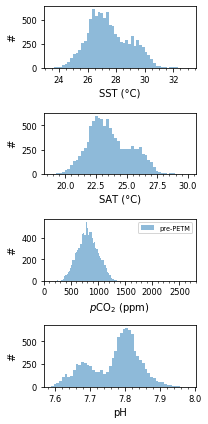

In [ ]:
# Calculate mean and std of each variable for each time slice
# plot the ensemble values
#####################    User defined start   #####################
label_all = ('prePETM', 'peakPETM','postPETM', 'PETM_body')
label_all_len = len(label_all)
warmcomp = [0,1]  # ID for petm warming
dat = pandas.DataFrame()
xlist = ('SST (U+2103)')
ylist = ()
print('')
print('DA - Summary of global mean and standard deviation')
print('')
#####################    User defined end     #####################

for locRadi in range(locRadn):
    locRad = local_rad_list[locRadi]
    if locRad is None:
        locRadv = 0 # for filename only
    else:
        locRadv = locRad
        
    for proxy_fraci in range(proxy_fracn):
        proxy_frac = proxy_frac_list[proxy_fraci]
        
        for Rscalei in range(Rscalen):
            Rscale = Rscale_list[Rscalei]
            
            # 2d variables
            for Xa2d_vari in range(prior_variable_len):
                
                print(prior_variable_dict[Xa2d_vari])
                
                df2 = pandas.DataFrame({'field':prior_variable_dict[Xa2d_vari],'mean':[np.nan],'std':[np.nan],'label':'-'}, index=[Xa2d_vari])
                df = pandas.concat([df,df2])
                
                sst_std_mc = np.std(Xa2d_mean_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,:],axis=0)
                print('  _locR '+str(locRadv)+' proxy_frac '+str(proxy_frac)+' scaled r '+str(Rscale))

                for reconi in range(recon_period_len):
                    
                    meani = np.nanmean(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi])
                    stdi = np.std(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi])
                    df2 = pandas.DataFrame({'field':'','mean':[meani],'std':[stdi],'label':label_all[reconi]}, index=[Xa2d_vari])
                    df = pandas.concat([df,df2])
                    print('    {:.3f} ± {:.3f}: {}'.format(meani, stdi, label_all[reconi]))
                    
                    if recon_period_len>2:
                        warmpeak = Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,1]-Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,0]
                        #warmbody = Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,2]-Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,0]
                        coolpeak = Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,1]-Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,2]
                        warmpeakmean = np.nanmean(warmpeak)
                        warmpeakstd = np.std(warmpeak)
                        coolpeakmean = np.nanmean(coolpeak)
                        coolpeakstd = np.std(coolpeak)
                        
                if recon_period_len>2:
                    df2 = pandas.DataFrame({'field':'','mean':[warmpeakmean],'std':[warmpeakstd],'label':'Peak_warming'}, index=[Xa2d_vari])
                    df3 = pandas.DataFrame({'field':'','mean':[coolpeakmean],'std':[coolpeakstd],'label':'Peak_cooling'}, index=[Xa2d_vari])
                    df = pandas.concat([df,df2,df3])
                    print('    {:.6f} ± {:.6f}: peak warming'.format(warmpeakmean,warmpeakstd))
                    print('    {:.6f} ± {:.6f}: peak cooling'.format(coolpeakmean,coolpeakstd))

                plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':110})
                fig = plt.figure()
                for reconi in range(recon_period_len):
                    kwargs = dict(alpha=0.5, bins=60)
                    if prior_variable_dict[Xa2d_vari] in ['atm_pCO2']:
                        #plt.hist(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi]*1e6, **kwargs, label = label_all[reconi])
                        plt.gca().set(xlabel = prior_variable_dict[Xa2d_vari]+ ' (ppm)');
                    else:
                        plt.gca().set(xlabel = prior_variable_dict[Xa2d_vari]);
                    plt.hist(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi], **kwargs, label = label_all[reconi])
                    #plt.gca().set(title='Frequency Histogram: locR '+str(locRadv)+' proxy_frac '+str(proxy_frac)+' scaled r '+str(Rscale), ylabel='Frequency');                    
                    if Xa2d_vari == 0:
                        plt.legend();

In [5]:
### Purpose of this block
# Prepare data for verification
### Steps
# 1. Prepare matrix for data saving: proxy, prior, posterior; std or not
# 2. calculate and save each Monte Carlo runs

#####################    User defined start   #####################
verbose = True
Typelist = ['d18O','TEX86','MgCa','caco3']
#Typelist = ['caco3']
#Typelist = ['d18O','TEX86','MgCa']
print('DA - Read proxy, prior, and posterior, standardize')
print('')
#####################    User defined end     #####################
locRad = local_rad_list[0]
if locRad is None:
    locRadv = 0 # for filename only
else:
    locRadv = locRad
proxy_frac = proxy_frac_list[0]
Rscale = Rscale_list[0]
filename_short = '_loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale),'_MC_0.hdf5'
hdf5name = MC_dir + ''.join(filename_short)
print('Read first hdf5 file {} to get the number of withold datasets.'.format(hdf5name))
sites_eval = pandas.read_hdf(hdf5name, 'sites_eval')
sites_withhold_len  = len(sites_eval)
print(' Site withhold length ： {}'.format(sites_withhold_len))

# Prepare empty matrix for saving the data of proxy, prior, and posterior
ob_stat = np.full((locRadn,proxy_fracn,Rscalen,MCn, recon_period_len*2, sites_withhold_len), np.nan)
xb_stat = np.full((locRadn,proxy_fracn,Rscalen,MCn, 2, sites_withhold_len), np.nan)   # save full prior for withhold data
xa_stat = np.full((locRadn,proxy_fracn,Rscalen,MCn, recon_period_len*2, sites_withhold_len), np.nan)

# Prepare empty matrix for saving the data of proxy, prior, and posterior; standardized
ob_std = np.copy(ob_stat)
xb_std = np.copy(xb_stat)
xa_std = np.copy(xa_stat)

# calculate each Monte Carlo runs
for locRadi in range(locRadn):
    locRad = local_rad_list[locRadi]
    if locRad is None:
        locRadv = 0 # for filename only
    else:
        locRadv = locRad
        
    for proxy_fraci in range(proxy_fracn):
        proxy_frac = proxy_frac_list[proxy_fraci]
        
        for Rscalei in range(Rscalen):
            Rscale = Rscale_list[Rscalei]
            
            for MCi in range(MCn):
            #for MCi in range(1):
                # NetCDF file name
                filename_short = '_loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale),'_MC_' + str(MCi)
                nc_filename = MC_dir + ''.join(filename_short) + '.nc'
                hdf5name    = MC_dir + ''.join(filename_short) + '.hdf5'
                print('    {}'.format(nc_filename))
                
                ### Read Proxy ###
                proxies=pandas.read_hdf(hdf5name, 'proxies')
                prior_variable_dict = pandas.read_hdf(hdf5name, 'prior_variable_dict')
                
                if proxy_frac <= 1.0:
                    sites_eval = pandas.read_hdf(hdf5name, 'sites_eval')
                    sites_withhold_len  = len(sites_eval)                    
                    if verbose:
                        print('Site withhold:       {}'.format(sites_eval['Site'].values))
                        print('Proxy        :       {}'.format(sites_eval['Proxy'].values))
                
                proxy_psm_type_dict_df = pandas.read_hdf(hdf5name, 'proxy_psm_type_dict_df')
                proxy_psm_type_dict_list = proxy_psm_type_dict_df[0].values.tolist()

                for j in range(sites_withhold_len):
                    data_psm_type = sites_eval['Proxy'][j]
                    for key, value in proxy_assim2.items():
                        if data_psm_type in value:
                            #print(proxy_psm_type[key])
                            key0 = key
                            psm_required_variable_key = list(yml_dict['psm'][proxy_psm_type[key]]['psm_required_variables'].keys())[0]
                            xb_key = psm_required_variable_key+'_Xb_full'
                            xa_key = psm_required_variable_key+'_Xa_full'
                            #print('xa_key is {}'.format(xa_key))
                            Xb_full_field0 = Dataset(nc_filename).variables[xb_key] #
                            Xb_full_field0 = Xb_full_field0[:,:,:,0].reshape(dum_imax*dum_jmax, nens)                        
                            Xa_full_field0 = Dataset(nc_filename).variables[xa_key]
                        
                    if proxy_psm_type[key0] in ['bayesreg_tex86', 'bayesreg_d18o_pooled', 'cgenie_caco3']:
                        Ye = DeepDA_psm.cal_ye_cgenie(yml_dict,sites_eval,j,Xb_full_field0,proxy_assim2,proxy_psm_type,dum_lon_offset,dum_imax,dum_jmax)
                        #Ye = DeepDA_psm.cal_ye_cgenie(yml_dict,sites_eval,j,Xb0,proxy_assim2,proxy_psm_type,dum_lon_offset,dum_imax,dum_jmax)
                        xb_stat[locRadi][proxy_fraci][Rscalei][MCi][0][j] = np.mean(Ye)
                        xb_stat[locRadi][proxy_fraci][Rscalei][MCi][1][j] = np.var(Ye)
                        #print('Prior Ye is {:.6f}'.format(np.mean(Ye)))
                        for reconi in range(recon_period_len):
                            Xa_reconi = Xa_full_field0[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))
                            Ye = DeepDA_psm.cal_ye_cgenie(yml_dict,sites_eval,j,Xa_reconi,proxy_assim2,proxy_psm_type,dum_lon_offset,dum_imax,dum_jmax)
                            xa_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][j]   = np.mean(Ye)
                            xa_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][j] = np.var(Ye)
                            #print('Analysis Ye is {:.6f}'.format(np.mean(Ye)))

                            #ob_stat[j][reconi*2]   = sites_eval[data_period_id[reconi]][j]
                            ob_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][j] = sites_eval[data_period_id[reconi]][j]
                            if ~np.isnan(sites_eval[data_period_id[reconi]][j]):
                                if proxy_psm_type[key0] in ['bayesreg_tex86']:
                                    if proxy_err_eval in ['proxy_err_psm']:
                                        ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = DeepDA_psm.obs_estimate_r_fixed_tex86(31) + sites_eval[data_period_idstd[reconi]][j] ** 2
                                    else:
                                        ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = DeepDA_psm.obs_estimate_r_fixed_tex86(31)                                        
                                if proxy_psm_type[key0] in ['bayesreg_d18o_pooled']:
                                    if proxy_err_eval in ['proxy_err_psm']:
                                        ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = DeepDA_psm.obs_estimate_r_fixed_d18o(15) + sites_eval[data_period_idstd[reconi]][j] ** 2
                                    else:
                                        ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = DeepDA_psm.obs_estimate_r_fixed_d18o(15)                                        
                                if proxy_psm_type[key0] in ['cgenie_caco3','cgenie_caco3_13c']:
                                    psm_error = yml_dict['psm'][proxy_psm_type[key0]]['psm_error']
                                    if proxy_err_eval in ['proxy_err_psm']:
                                        ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = psm_error + sites_eval[data_period_idstd[reconi]][j] ** 2
                                    else:
                                        ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = psm_error
                                        
                    elif proxy_psm_type[key0] in ['bayesreg_mgca_pooled_bcp', 'bayesreg_mgca_pooled_red']:
                        spp = 'all'
                        cleaningr = np.tile(np.array([1]),nens)
                        cleaningb = np.tile(np.array([0]),nens)
                        if proxy_psm_type[key0] in ['bayesreg_mgca_pooled_red']:
                            clearning_one = cleaningr
                            proxy_explain = 'reductive'
                        elif proxy_psm_type[key0] in ['bayesreg_mgca_pooled_bcp']:
                            clearning_one = cleaningb
                            proxy_explain = 'barker'

                        #print('    Mg/Ca proxy found. Load salinity, pH and omega')
                        with h5py.File(hdf5name, 'r') as f:
                            Xb_sal = f.get('Xb_sal')
                            Xb_omega = f.get('Xb_omega')
                            Xb_ph = f.get('Xb_ph')
                            Ye = DeepDA_psm.cal_ye_cgenie_mgca(yml_dict,sites_eval,j,Xb_full_field0,proxy_psm_type[key0],dum_lon_offset,dum_imax,dum_jmax,Xb_sal,Xb_ph,Xb_omega,geologic_age)
                            #Ye = DeepDA_psm.cal_ye_cgenie_mgca(yml_dict,sites_eval,j,Xb0,proxy_psm_type[key0],dum_lon_offset,dum_imax,dum_jmax,Xb_sal,Xb_ph,Xb_omega,geologic_age)
                            xb_stat[locRadi][proxy_fraci][Rscalei][MCi][0][j] = np.mean(Ye)
                            xb_stat[locRadi][proxy_fraci][Rscalei][MCi][1][j] = np.var(Ye)
                        Xa_sal_full = Dataset(nc_filename).variables['ocn_sur_sal_Xa_full']
                        Xa_ph_full  = Dataset(nc_filename).variables['misc_pH_Xa_full']
                        Xa_omega_full = Dataset(nc_filename).variables['carb_sur_ohm_cal_Xa_full']

                        for reconi in range(recon_period_len):
                            Xa_reconi = Xa_full_field0[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))
                            Xb_sal   =   Xa_sal_full[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))
                            Xb_ph    =    Xa_ph_full[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))
                            Xb_omega = Xa_omega_full[:,:,:,0,reconi].reshape((dum_imax*dum_jmax,nens))

                            Ye = DeepDA_psm.cal_ye_cgenie_mgca(yml_dict,sites_eval,j,Xa_reconi,proxy_psm_type[key0],dum_lon_offset,dum_imax,dum_jmax,Xb_sal,Xb_ph,Xb_omega,geologic_age)
                            xa_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][j]   = np.mean(Ye)
                            xa_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][j] = np.var(Ye)

                            ob_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][j] = sites_eval[data_period_id[reconi]][j]
                            if ~np.isnan(sites_eval[data_period_id[reconi]][j]):
                                ob_err0 = DeepDA_psm.obs_estimate_r_fixed_mgca_pooled((15, 16), clearning_one[0], np.nanmean(Xb_sal), np.nanmean(Xb_ph), np.nanmean(Xb_omega), spp, geologic_age)
                                if proxy_err_eval in ['proxy_err_psm']:
                                    ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = ob_err0 + sites_eval[data_period_idstd[reconi]][j] ** 2
                                else:
                                    ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][j] = ob_err0
                
                # save proxy, prior, and posterior data and then standardized
                
                xb_std[locRadi][proxy_fraci][Rscalei][MCi][1][:] = np.copy(xb_stat[locRadi][proxy_fraci][Rscalei][MCi][1][:])
                # for each time slices
                for reconi in range(recon_period_len):
                    ob_std[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][:] = np.copy(ob_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][:])
                    xa_std[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][:] = np.copy(xa_stat[locRadi][proxy_fraci][Rscalei][MCi][reconi*2+1][:])
                    # for each proxy type
                    id1 = 0
                    for ki in range(len(Typelist)):
                        
                        sites_s = sites_eval[sites_eval.Type == Typelist[ki]]
                        
                        if reconi + MCi == 0:
                            print('# withhold datasets of {}: {}'.format(Typelist[ki], len(sites_s)))
                        id2 = id1 + len(sites_s)
                        
                        # select observations which type is the same
                        ob_s = ob_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                        ct_nonnan0 = sum(~np.isnan(ob_s)) # count non nan values
                        #print('  Count non nan values {}'.format(ct_nonnan0 ))
                        if ct_nonnan0 >= 1:
                            print('observation withhold {}'.format(ob_s))
                            ob_s_std = stats.zscore(ob_s, nan_policy = 'omit')
                            ob_std[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][id1:id2] = np.copy(ob_s_std)
                            
                        # select posterior/analysis which type is the same
                        xa_s = xa_stat[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                        ct_nonnan1 = sum(~np.isnan(xa_s)) # count non nan values
                        if ct_nonnan1 >= 1:
                            xa_s_std = stats.zscore(xa_s, nan_policy = 'omit')
                            xa_std[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][id1:id2] = np.copy(xa_s_std)
                            
                        if reconi == 0:
                            # select prior/model which type is the same
                            xb_s = xb_stat[locRadi][proxy_fraci][Rscalei][MCi][0][sites_eval.Type == Typelist[ki]]
                            ct_nonnan2 = sum(~np.isnan(xb_s)) # count non nan values
                            if ct_nonnan2 >= 1:
                                xb_s_std = stats.zscore(xb_s, nan_policy = 'omit')
                                xb_std[locRadi][proxy_fraci][Rscalei][MCi][0][id1:id2] = np.copy(xb_s_std)
                                
                        id1 = id2

print('Done.')

DA - Read proxy, prior, and posterior, standardize

Read first hdf5 file /mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.18.csv_petm17_v18_2020824_T_20mc/_loc_0_proxy_frac_0.7_Rscale_1.0_MC_0.hdf5 to get the number of withold datasets.
 Site withhold length ： 5
    /mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.18.csv_petm17_v18_2020824_T_20mc/_loc_0_proxy_frac_0.7_Rscale_1.0_MC_0.nc
Site withhold:       ['302' '1172' 'fur' 'harrell' 'waipara']
Proxy        :       ['tex86' 'tex86' 'tex86' 'tex86' 'tex86']
  Warning. search_tol may be too small. try a larger number + 10
  Warning. search_tol may be too small. try a larger number + 10
# withhold datasets of d18O: 0
# withhold datasets of TEX86: 5
observation withhold [0.608182 0.6555   0.53     0.72619  0.5373  ]
# withhold datasets of MgCa: 0
# withhold datasets of caco3: 0
observation withhold [0.63     0.82     0.77     0.889    0.856915]
    /mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.18.csv_petm17_v18_2020824_T_20mc/_loc_0_proxy_frac_0.7_Rscale_1.0_M

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



  Warning. search_tol may be too small. try a larger number + 10
Traceback (most recent call last):
  File "/mnt/c/Users/mul450/Dropbox/git/deepDA/DeepDA_lib/DeepDA_psm.py", line 300, in cal_ye_cgenie
    prediction = bayspar.predict_tex_analog(prior_1grid, temptype = 'sst', search_tol = search_tol_i, nens=nens_i)
  File "/home/mul450/miniconda3/envs/lmr_py3/lib/python3.6/site-packages/bayspar/predict.py", line 153, in predict_tex_analog
    sys.exit('No analogs were found. Check seatemp or make your search tolerance wider.')
SystemExit: No analogs were found. Check seatemp or make your search tolerance wider.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mul450/miniconda3/envs/lmr_py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-df4b91ef5dc8>", line 97, in <module>
    Ye = DeepDA_psm.cal_ye_cge

SystemExit: No analogs were found. Check seatemp or make your search tolerance wider.

/home/mul450/miniconda3/envs/lmr_py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
# show one MC results

validthisblock = 1

if validthisblock> 0:
    print(MCi)
    print('Done. Show first time-slice data of')
    print(' xb_std ')
    print(xb_std[locRadi,proxy_fraci,Rscalei,MCi,0,:])
    print(' and ')
    print('  ')
    print(' xa_std ')
    print(xa_std[locRadi,proxy_fraci,Rscalei,MCi,0,:])
    print(' ob_std ')
    print(ob_std[locRadi,proxy_fraci,Rscalei,MCi,0,:])
    print('  ')
    if validthisblock>1:
        print('2 nd slice peakPETM')
        print(' xa_std ')
        print(xa_std[locRadi,proxy_fraci,Rscalei,MCi,2,:])
        print(' ob_std ')
        print(ob_std[locRadi,proxy_fraci,Rscalei,MCi,2,:])
        print('  ')
        print('  ')

    print('. Show first time-slice data of')
    print(' xb_stat ')
    print(xb_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:])
    print(' and ')
    print('  ')
    print(' xa_stat ')
    print(xa_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:])
    print(' ob_stat ')
    print(ob_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:])
    print('  ')
    if validthisblock>1:
        print('2 nd slice peakPETM')
        print(' xa_stat ')
        print(xa_stat[locRadi,proxy_fraci,Rscalei,MCi,2,:])
        print(' ob_stat ')
        print(ob_stat[locRadi,proxy_fraci,Rscalei,MCi,2,:])
        print('  ')

9
Done. Show first time-slice data of
 xb_std 
[-1.517516 -1.519367  1.113368 -0.87799   0.120794  0.29418   0.293137
  1.047157  1.046236  1.       -1.        0.491767 -1.394197  0.90243 ]
 and 
  
 xa_std 
[-1.521092 -1.520675  1.111916 -0.873045  0.12535   0.293431  0.292193
  1.046473  1.045449  1.       -1.        0.502047 -1.395996  0.893949]
 ob_std 
[-0.937953 -0.220523       nan -0.51634        nan  1.674816       nan
       nan       nan  1.       -1.        0.921301 -1.389845  0.468544]
  
. Show first time-slice data of
 xb_stat 
[ 0.819608 -4.857895 -4.85942  -2.690882 -4.331129  4.315819 -3.508447
  3.466921 -3.365633 -3.366492  0.741219 -2.745419 -2.746177  4.500664]
 and 
  
 xa_stat 
[ 0.825708 -4.963862 -4.963517 -2.786015 -4.427841  4.22961  -3.602036
  3.406064 -3.463011 -3.464035  0.747298 -2.840145 -2.840992  4.399653]
 ob_stat 
[ 0.84429  -3.437143 -3.132308       nan -3.258     4.33167        nan
  3.68267  -2.32698        nan  0.72619        nan       nan  4.20


NSE & RMSE calculation ... 
    raw data used 
    each time slice calculated 
      NSE & RMSE calculation: Done!
  prePETM
    mean of CE   [0.891225 0.87466 ]
    mean of RMSE [0.727305 0.768868]
  peakPETM
    mean of CE   [0.916219 0.92536 ]
    mean of RMSE [0.892566 0.822536]
  NSE & RMSE calculation ... 
    raw data used 
    all time slice together 
      NSE & RMSE calculation: Done!
      mean of CE   [0.916491 0.921931]
      mean of RMSE [0.834985 0.802595]

NSE & RMSE calculation ... 
    standardized data used 
    each time slice calculated 
      NSE & RMSE calculation: Done!
  prePETM
    mean of CE   [0.422671 0.42186 ]
    mean of RMSE [0.713213 0.714148]
  peakPETM
    mean of CE   [0.310559 0.302102]
    mean of RMSE [0.816824 0.822335]
  NSE & RMSE calculation ... 
    standardized data used 
    all time slice together 
      NSE & RMSE calculation: Done!
      mean of CE   [0.381299 0.376201]
      mean of RMSE [0.780362 0.783724]


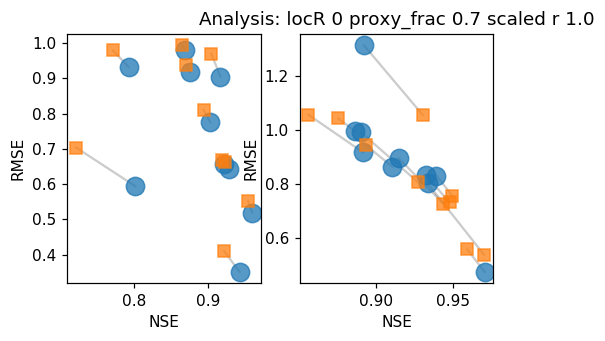

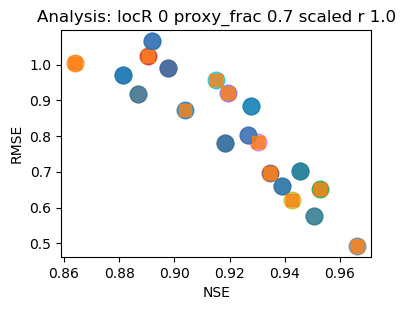

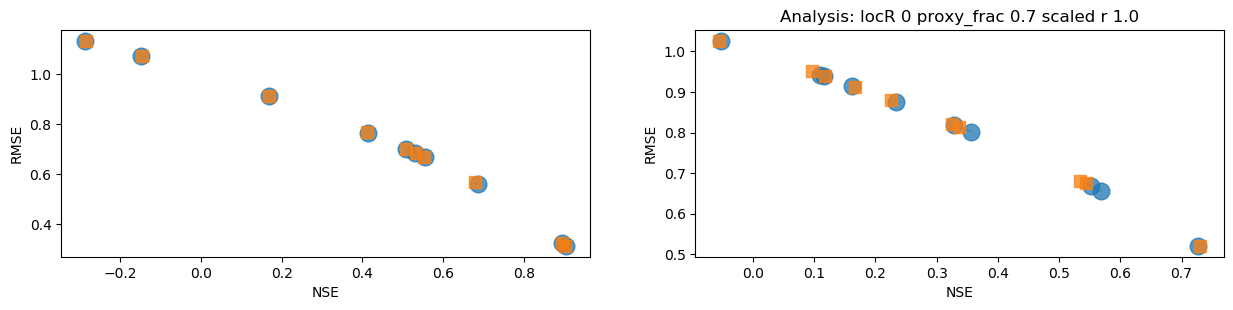

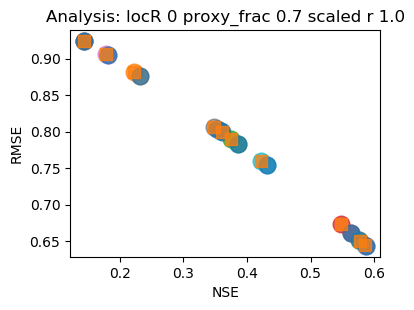

In [5]:
# validataion
# calculate CE and RMSE for each time slices
# plot CE and RMSE

stdtf = [False, True] # True: standardize; False: use raw analysis data
cetf = [False,True] # True: calculate ce in all; False: calculate ce for each time slice
verbose = False

for stdi in range(2):
    for allcei in range(2):
        allce = cetf[allcei]
        AnalysisStd = stdtf[stdi]
        if allcei == 0:
            print('')
            print('NSE & RMSE calculation ... ')
        else:            
            print('  NSE & RMSE calculation ... ')
        if AnalysisStd:
            ob_stat_select = np.copy(ob_std)
            xb_stat_select = np.copy(xb_std)
            xa_stat_select = np.copy(xa_std)
            print('    standardized data used ')
        else:
            ob_stat_select = np.copy(ob_stat)
            xb_stat_select = np.copy(xb_stat)
            xa_stat_select = np.copy(xa_stat)
            print('    raw data used ')

        # calculate NSE & RMSE
        if allce:
            CE_stat = np.full((locRadn,proxy_fracn,Rscalen,MCn,2), np.nan)
            RMSE_stat=np.full((locRadn,proxy_fracn,Rscalen,MCn,2), np.nan)
            print('    all time slice together ')
            CE_all = np.full((locRadn,proxy_fracn,Rscalen,2), np.nan)
            RMSE_all=np.full((locRadn,proxy_fracn,Rscalen,2), np.nan)
        else:
            CE_stat = np.full((locRadn,proxy_fracn,Rscalen,MCn,2,recon_period_len), np.nan)
            RMSE_stat=np.full((locRadn,proxy_fracn,Rscalen,MCn,2,recon_period_len), np.nan)
            print('    each time slice calculated ')
            
        
        
        reconlist = np.arange(0,2*recon_period_len,2)
        # calculate each Monte Carlo runs
        for locRadi in range(locRadn):
            locRad = local_rad_list[locRadi]
            if locRad is None:
                locRadv = 0 # for filename only
            else:
                locRadv = locRad

            for proxy_fraci in range(proxy_fracn):
                proxy_frac = proxy_frac_list[proxy_fraci]

                for Rscalei in range(Rscalen):
                    Rscale = Rscale_list[Rscalei]
                    
                    if allce:
                        dataall     = ob_stat_select[locRadi,proxy_fraci,Rscalei,:,reconlist,:].flatten('F')
                        modelall    = np.matlib.repmat(xb_stat_select[locRadi,proxy_fraci,Rscalei,:,0,:],reconi+1,1).flatten('F')
                        analysisall = xa_stat_select[locRadi,proxy_fraci,Rscalei,:,reconlist,:].flatten('F')
                        CE_all[locRadi,proxy_fraci,Rscalei,0] = DeepDA_psm.CE_NS70(dataall, modelall,1)
                        CE_all[locRadi,proxy_fraci,Rscalei,1] = DeepDA_psm.CE_NS70(dataall, analysisall,1)
                        RMSE_all[locRadi,proxy_fraci,Rscalei,0] = np.sqrt(np.nanmean((modelall - dataall) ** 2))
                        RMSE_all[locRadi,proxy_fraci,Rscalei,1] = np.sqrt(np.nanmean((analysisall - dataall) ** 2))
                        if verbose:
                            filename_short = '      _loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale)
                            print('>>{}'.format(filename_short))
                            print('>>  all data     {}'.format(dataall))
                            print('>>  all model    {}'.format(modelall))
                            print('>>  all analysis {}'.format(analysisall))
                            print('>>  Prior    CE: obs vs. xb {}'.format(CE_all[locRadi,proxy_fraci,Rscalei,0]))
                            print('>>  Analysis CE: obs vs. xa {}'.format(CE_all[locRadi,proxy_fraci,Rscalei,1]))
                            print('>>  Prior    RMSE: obs vs. xb {}'.format(RMSE_all[locRadi,proxy_fraci,Rscalei,0]))
                            print('>>  Analysis RMSE: obs vs. xa {}'.format(RMSE_all[locRadi,proxy_fraci,Rscalei,1]))

                    for MCi in range(MCn):
                        filename_short = '      _loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale),'_MC_' + str(MCi)
                        data     = ob_stat_select[locRadi,proxy_fraci,Rscalei,MCi,reconlist,:]
                        model    = np.matlib.repmat(xb_stat_select[locRadi,proxy_fraci,Rscalei,MCi,0,:],reconi+1,1)
                        analysis = xa_stat_select[locRadi,proxy_fraci,Rscalei,MCi,reconlist,:]
                        if verbose:
                            print('>>{}'.format(filename_short))
                            print('>>  data     {}'.format(data))
                            print('>>  model    {}'.format(model))
                            print('>>  analysis {}'.format(analysis))
                        if allce:
                            data     = data.flatten('F')
                            model    = model.flatten('F')
                            analysis = analysis.flatten('F')                                           
                            CE_stat[locRadi,proxy_fraci,Rscalei,MCi,0] = DeepDA_psm.CE_NS70(data, model,1)
                            CE_stat[locRadi,proxy_fraci,Rscalei,MCi,1] = DeepDA_psm.CE_NS70(data, analysis,1)                            
                            RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,0] = np.sqrt(np.nanmean((model - data) ** 2))
                            RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,1] = np.sqrt(np.nanmean((analysis - data) ** 2))
                            if verbose:
                                print('>>  Prior    CE: obs vs. xb {}'.format(CE_stat[locRadi,proxy_fraci,Rscalei,MCi,0]))
                                print('>>  Analysis CE: obs vs. xa {}'.format(CE_stat[locRadi,proxy_fraci,Rscalei,MCi,1]))
                                print('>>  Prior    RMSE: obs vs. xb {}'.format(RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,0]))
                                print('>>  Analysis RMSE: obs vs. xa {}'.format(RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,1]))
                        else:
                            CE_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:] = DeepDA_psm.CE_NS70(data, model, 0)
                            CE_stat[locRadi,proxy_fraci,Rscalei,MCi,1,:] = DeepDA_psm.CE_NS70(data, analysis, 0)
                            RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:] = np.sqrt(np.nanmean((model - data) ** 2, axis=1))
                            RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,1,:] = np.sqrt(np.nanmean((analysis - data) ** 2, axis=1))
                            if verbose:
                                print('>>  Prior    CE: obs vs. xb {}'.format(CE_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:]))
                                print('>>  Analysis CE: obs vs. xa {}'.format(CE_stat[locRadi,proxy_fraci,Rscalei,MCi,1,:]))
                                print('>>  Prior    RMSE: obs vs. xb {}'.format(RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,0,:]))
                                print('>>  Analysis RMSE: obs vs. xa {}'.format(RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,1,:]))
        print('      NSE & RMSE calculation: Done!')
        
        # PLot
        # calculate each Monte Carlo runs
        for locRadi in range(locRadn):
            locRad = local_rad_list[locRadi]
            if locRad is None:
                locRadv = 0 # for filename only
            else:
                locRadv = locRad

            for proxy_fraci in range(proxy_fracn):
                proxy_frac = proxy_frac_list[proxy_fraci]

                for Rscalei in range(Rscalen):
                    Rscale = Rscale_list[Rscalei]
                    
                    fig = plt.figure()                    
                    if allce:
                        kwargs = dict(alpha=0.75, marker='o', markersize=12, linestyle='',label = 'Prior')
                        for MCi in range(MCn):
                            plt.plot(CE_stat[locRadi,proxy_fraci,Rscalei,MCi,:],RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,:], **kwargs)
                            
                        kwargs = dict(alpha=0.75, marker='o', markersize=12, linestyle='',label = 'Prior')
                        plt.plot(CE_stat[locRadi,proxy_fraci,Rscalei,:,0],RMSE_stat[locRadi,proxy_fraci,Rscalei,:,0], **kwargs)
                        plt.gca().set(ylabel='RMSE', xlabel = 'NSE');
                        #plt.legend();

                        kwargs = dict(alpha=0.75, marker='s', markersize=8, linestyle='',label = 'Analysis')
                        plt.plot(CE_stat[locRadi,proxy_fraci,Rscalei,:,1],RMSE_stat[locRadi,proxy_fraci,Rscalei,:,1], **kwargs)
                        #plt.legend();
                        
                        plt.gca().set(title='Analysis: locR '+str(locRadv)+' proxy_frac '+str(proxy_frac)+' scaled r '+str(Rscale), ylabel='RMSE', xlabel = 'NSE');

                        CEmean = np.mean(CE_stat[locRadi,proxy_fraci,Rscalei,:,:],axis = 0)
                        RMSEmean=np.mean(RMSE_stat[locRadi,proxy_fraci,Rscalei,:,:],axis = 0)
                        print('      mean of CE   {}'.format(CEmean))
                        print('      mean of RMSE {}'.format(RMSEmean))
                        plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':100})
                        
                    else:
                        
                        for reconi in range(recon_period_len):

                            plt.subplot(1, recon_period_len, reconi+1)
                            kwargs = dict(alpha=0.2, linestyle='-', color = 'k')
                            
                            for MCi in range(MCn):
                                plt.plot(CE_stat[locRadi,proxy_fraci,Rscalei,MCi,:,reconi],RMSE_stat[locRadi,proxy_fraci,Rscalei,MCi,:,reconi], **kwargs)

                            kwargs = dict(alpha=0.75, marker='o', markersize=12, linestyle='',label = 'Prior '+label_all[reconi])
                            plt.plot(CE_stat[locRadi,proxy_fraci,Rscalei,:,0,reconi],RMSE_stat[locRadi,proxy_fraci,Rscalei,:,0,reconi], **kwargs)
                            plt.gca().set(ylabel='RMSE', xlabel = 'NSE');
                            #plt.legend();

                            kwargs = dict(alpha=0.75, marker='s', markersize=8, linestyle='',label = 'Analysis '+label_all[reconi])
                            plt.plot(CE_stat[locRadi,proxy_fraci,Rscalei,:,1,reconi],RMSE_stat[locRadi,proxy_fraci,Rscalei,:,1,reconi], **kwargs)
                            #plt.legend();
                            if reconi == 1:
                                plt.gca().set(title='Analysis: locR '+str(locRadv)+' proxy_frac '+str(proxy_frac)+' scaled r '+str(Rscale), ylabel='RMSE', xlabel = 'NSE');

                            print('  {}'.format(label_all[reconi]))
                            CEmean = np.mean(CE_stat[locRadi,proxy_fraci,Rscalei,:,:,reconi],axis = 0)
                            RMSEmean=np.mean(RMSE_stat[locRadi,proxy_fraci,Rscalei,:,:,reconi],axis = 0)
                            print('    mean of CE   {}'.format(CEmean))
                            print('    mean of RMSE {}'.format(RMSEmean))
                            plt.rcParams.update({'figure.figsize':(4,3), 'figure.dpi':100})

No handles with labels found to put in legend.


standardized data used 
  each time slice calculated 


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


raw data used ... 
  each time slice calculated 


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


standardized data used 
  all time slice used 
raw data used ... 
  all time slice used 


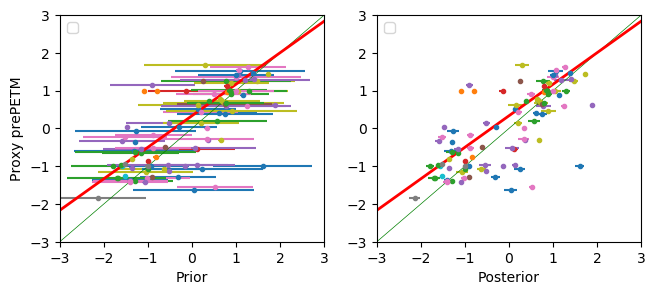

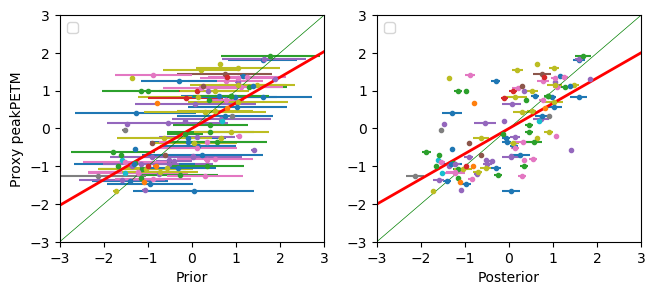

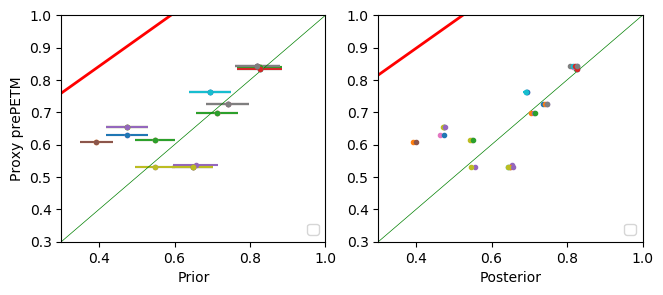

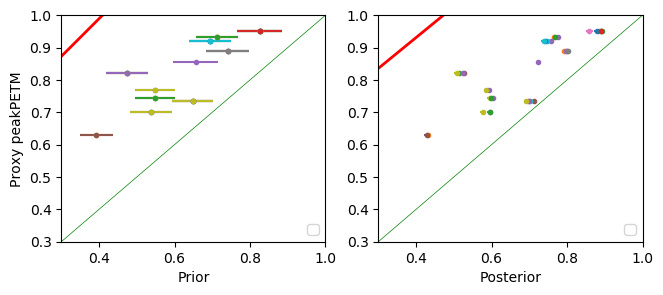

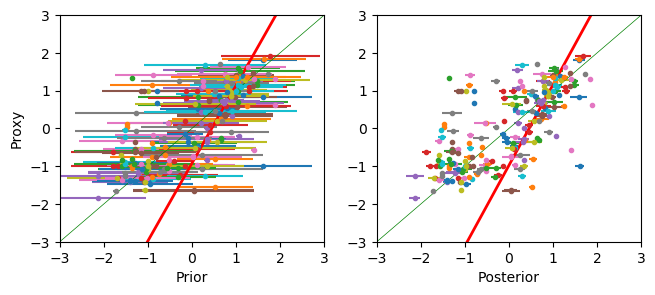

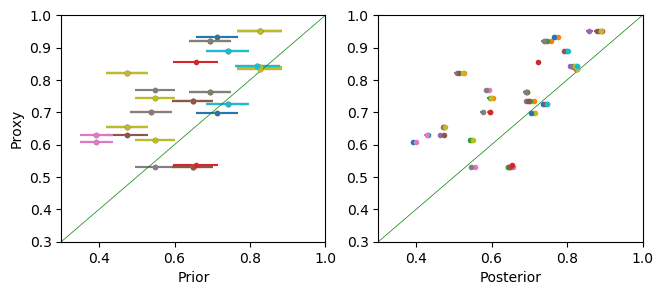

In [6]:
# correlation
# plot data-model comparison before and after DA
# show equation and line

plotn = 1

limoption = 'tex'

if limoption in ['tex']:
    lims = 0.3
    lime = 1.0
if limoption in ['o18']:
    lims = 0.3
    lime = 1.0
if limoption in ['mgca']:
    lims = 0.3
    lime = 6.0

stdtf = [True, False] # True: standardize; False: use raw analysis data
cetf = [False, True] # True: calculate ce in all; False: calculate ce for each time slice

for allcei in range(2):
    for stdi in range(2):
    
        allce = cetf[allcei]
        AnalysisStd = stdtf[stdi]

        if AnalysisStd:
            lim1 = -3
            ob_stat_select = np.copy(ob_std)
            xb_stat_select = np.copy(xb_std)
            xa_stat_select = np.copy(xa_std)
            print('standardized data used ')
            lim2 = -1 * lim1
        else:
            lim1 = lims
            lim2 = lime
            ob_stat_select = np.copy(ob_stat)
            xb_stat_select = np.copy(xb_stat)
            xa_stat_select = np.copy(xa_stat)
            print('raw data used ... ')
       
        if allce:
            print('  all time slice used ')
        else:
            print('  each time slice calculated ')

        if plotn > 0:

            for locRadi in range(locRadn):
                locRad = local_rad_list[locRadi]
                if locRad is None:
                    locRadv = 0 # for filename only
                else:
                    locRadv = locRad

                for proxy_fraci in range(proxy_fracn):
                    proxy_frac = proxy_frac_list[proxy_fraci]

                    for Rscalei in range(Rscalen):
                        Rscale = Rscale_list[Rscalei]
                        
                        if allce:
                            plt.rcParams.update({'figure.figsize':(10,2), 'figure.dpi':100})
                            fig = plt.figure(figsize=(7.5, 3), dpi=100)
                            for kki in range(2):
                                varyall = np.full((recon_period_len*sites_withhold_len), np.nan)
                                varxall = np.full((recon_period_len*sites_withhold_len), np.nan)
                                if kki == 0:
                                    subploti = 121
                                else:
                                    subploti = 122
                                plt.subplot(subploti)
                                plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
                                if kki == 0:
                                    # before DA
                                    plt.xlabel('Prior')
                                    plt.ylabel('Proxy')
                                    
                                    
                                    for ki in range(len(Typelist)):
                                        for reconi in range(recon_period_len):
                                            for MCi in range(MCn):
                                                ob_stat_selecti = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                                                y1  = ob_stat_selecti.flatten('F')
                                                ye1 = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][sites_eval.Type == Typelist[ki]].flatten('F')
                                                x1  = xb_stat_select[locRadi][proxy_fraci][Rscalei][MCi][0][sites_eval.Type == Typelist[ki]]
                                                xe1 = xb_stat_select[locRadi][proxy_fraci][Rscalei][MCi][1][sites_eval.Type == Typelist[ki]]
                                                #plt.errorbar(x1, y1, xerr = np.sqrt(xe1), yerr=np.sqrt(ye1), ls = '', label = Typelist[ki])
                                                plt.errorbar(x1, y1, xerr = np.sqrt(xe1), marker='.', ls = '')
                                                # linear regression
                                                id1 = 0
                                                idn = id1+y1.size
                                                varxall[id1:idn] = np.copy(x1)
                                                varyall[id1:idn] = np.copy(y1)
                                                id1 = idn

                                else:
                                    # after DA
                                    plt.xlabel('Posterior')
                                    for ki in range(len(Typelist)):
                                        for reconi in range(recon_period_len):
                                            for MCi in range(MCn):
                                                x1  = xa_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                                                xe1 = xa_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][sites_eval.Type == Typelist[ki]]
                                                y1  = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                                                ye1 = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][sites_eval.Type == Typelist[ki]]
                                                #plt.errorbar(x1, y1, xerr = np.sqrt(xe1), yerr=np.sqrt(ye1), ls = '', label = Typelist[ki])
                                                plt.errorbar(x1, y1, xerr = np.sqrt(xe1), marker='.', ls = '')

                                                id1 = 0
                                                idn = id1+y1.size
                                                varxall[id1:idn] = np.copy(x1)
                                                varyall[id1:idn] = np.copy(y1)
                                                id1 = idn

                                mask = ~np.isnan(varxall) & ~np.isnan(varyall)
                                slope, intercept, r_value, p_value, std_err = stats.linregress(varxall[mask], varyall[mask])
                                textstr = ('y = {:.3f} * x + {:.3f} \n r = {:.3f}'.format(slope, intercept,r_value))
                                #plt.text(1, 3, textstr, wrap=True)
                                plt.xlim(lim1,lim2)
                                plt.ylim(lim1,lim2)
                                
                                plt.plot(np.array([lim1,lim2]), np.array([lim1*slope+intercept,lim2*slope+intercept]), color='red',linewidth=2)
                                #plt.legend();
                        else:

                            plt.rcParams.update({'figure.figsize':(10,2), 'figure.dpi':100})

                            for reconi in range(recon_period_len):
                                fig = plt.figure(figsize=(7.5, 3), dpi=100)
                                
                                for kki in range(2):
                                    if kki == 0:
                                        subploti = 121
                                    else:
                                        subploti = 122
                                    plt.subplot(subploti)
                                    plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
                                    for MCi in range(MCn):
                                        if kki == 0:
                                            # before DA
                                            plt.xlabel('Prior')
                                            plt.ylabel('Proxy ' + label_all[reconi])
                                            for ki in range(len(Typelist)):
                                                x1  = xb_stat_select[locRadi][proxy_fraci][Rscalei][MCi][0][sites_eval.Type == Typelist[ki]]
                                                xe1 = xb_stat_select[locRadi][proxy_fraci][Rscalei][MCi][1][sites_eval.Type == Typelist[ki]]
                                                y1  = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                                                ye1 = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][sites_eval.Type == Typelist[ki]]
                                                #plt.errorbar(x1, y1, xerr = np.sqrt(xe1), yerr=np.sqrt(ye1), ls = '', label = Typelist[ki])
                                                plt.errorbar(x1, y1, xerr = np.sqrt(xe1), marker='.', ls = '')
                                                # linear regression
                                            varx = xb_stat_select[locRadi,proxy_fraci,Rscalei,MCi,0,:]
                                            vary = ob_stat_select[locRadi,proxy_fraci,Rscalei,MCi,2*reconi,:]
                                                #mask = ~np.isnan(varx) & ~np.isnan(vary)
                                                #slope, intercept, r_value, p_value, std_err = stats.linregress(varx[mask], vary[mask])
                                        else:
                                            # after DA
                                            plt.xlabel('Posterior')
                                            for ki in range(len(Typelist)):
                                                x1  = xa_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                                                xe1 = xa_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][sites_eval.Type == Typelist[ki]]
                                                y1  = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi][sites_eval.Type == Typelist[ki]]
                                                ye1 = ob_stat_select[locRadi][proxy_fraci][Rscalei][MCi][2*reconi+1][sites_eval.Type == Typelist[ki]]
                                                #plt.errorbar(x1, y1, xerr = np.sqrt(xe1), yerr=np.sqrt(ye1), ls = '', label = Typelist[ki])
                                                plt.errorbar(x1, y1, xerr = np.sqrt(xe1), marker='.', ls = '')
                                                # linear regression
                                            varx = xa_stat_select[locRadi,proxy_fraci,Rscalei,MCi,2*reconi,:]
                                            vary = ob_stat_select[locRadi,proxy_fraci,Rscalei,MCi,2*reconi,:]

                                    mask = ~np.isnan(varx) & ~np.isnan(vary)
                                    slope, intercept, r_value, p_value, std_err = stats.linregress(varx[mask], vary[mask])
                                    textstr = ('y = {:.3f} * x + {:.3f} \n r = {:.3f}'.format(slope, intercept,r_value))
                                    #plt.text(1, 3, textstr, wrap=True)
                                    plt.xlim(lim1,lim2)
                                    plt.ylim(lim1,lim2)
                                    plt.plot(np.array([lim1,lim2]), np.array([lim1*slope+intercept,lim2*slope+intercept]), color='red',linewidth=2)
                                    plt.legend();


In [14]:
# export jupyter notebook as html, for reference
os.system('jupyter nbconvert --to html DeepDA_verify_proxyunit.ipynb')
shutil.move("DeepDA_verify_proxyunit.html", MC_dir+"DeepDA_verify_proxyunit.html")

'/mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.17.csv_petm17_v17_2020721_Mg_pre-peak-PETM_10mc/DeepDA_verify_proxyunit.html'